# inforet 2

In [ ]:
# no time to lose:
!wget https://gerdes.fr/saclay/inforet/our_msmarco.zip
!unzip our_msmarco.zip
# this will be big: 1.2gb!
# you will get three files 

## ↓ go down to the section "reading in our smaller files"


In [9]:
# this turns on the autotimer, so that every cell has a timing information below
try:
    %load_ext autotime
except:
    !pip install ipython-autotime
    %load_ext autotime
# stop using:
# %unload_ext autotime
# !pip install sklearn

The autotime extension is already loaded. To reload it, use:
  %reload_ext autotime
time: 1.3 ms (started: 2025-03-27 09:12:34 +01:00)


In [1]:
import re
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from collections import Counter
from tqdm.notebook import tqdm
from sklearn.feature_extraction.text import CountVectorizer
import dask.dataframe as dd

## our dataset

- "TREC stands for the Text Retrieval Conference. Started in 1992 it is a series of workshops that focus on supporting research within the information retrieval community. It provides the infrastructure necessary for large-scale evaluation of text retrieval methodologies. Every year these workshops are organized, which are centered around a set of tracks. These tracks encourage new researches in the area of information retrieval."
- TREC 2019 Deep Learning Track https://microsoft.github.io/msmarco/TREC-Deep-Learning-2019
- data from MS-Marco https://microsoft.github.io/msmarco/
- The dataset contains  367k queries and a corpus of 3.2 million documents. 
___
- if you want to reproduce my selection or get a bigger set, uncomment and execute


In [ ]:
#!wget https://msmarco.blob.core.windows.net/msmarcoranking/msmarco-docs.tsv.gz
#!wget https://msmarco.blob.core.windows.net/msmarcoranking/msmarco-doctrain-queries.tsv.gz
#!wget https://msmarco.blob.core.windows.net/msmarcoranking/msmarco-doctrain-top100.gz
	
#!gzip -d msmarco-docs.tsv.gz
#!gzip -d msmarco-doctrain-queries.tsv.gz
#!gzip -d msmarco-doctrain-top100.gz


## skip to the section "reading in our smaller files"

come back here if you want to understand how to reduce the dataset or you want to build your own dataset

- we have three datasets:
    
    1. the queries: msmarco-doctrain-queries.tsv
    2. the gold: msmarco-doctrain-top100.tsv is a table containing query_id, doc_id and rank
    3. the actual documents: msmarco-docs.tsv 21GB of text! doc_id, url, title, text

In [ ]:
all_queries=pd.read_table('msmarco-doctrain-queries.tsv',header=None)
all_queries.columns=['qid','query']
print('Shape=>',all_queries.shape)
all_queries.head()

#### reducing the dataset
- here we take 1000 queries. 
- if this is too big for your computer, use this code to build smaller version, starting with the already reduced 1000 query set that we've downloaded before


In [ ]:
our_queries=all_queries.sample(n=1000,random_state=42).reset_index(drop=True)
print('Shape=>',our_queries.shape)
our_queries.head()

In [ ]:
our_queries.to_csv('our.msmarco.queries.tsv',sep='\t')

#### the gold file
- 36m lines!

In [ ]:
gold_top100=pd.read_table('msmarco-doctrain-top100',delimiter=' ',header=None)
gold_top100.columns=['qid','Q0','docid','rank','score','runstring']
print('Shape=>',gold_top100.shape)
display(gold_top100.head())
# Reducing train_top100 for training
our_gold_top100=train_top100[gold_top100['qid'].isin(our_queries['qid'].unique())].reset_index(drop=True)
print('Shape=>',our_gold_top100.shape)
our_gold_top100.head()

In [ ]:
our_gold_top100.to_csv('our.msmarco.gold.tsv',sep='\t')

#### the data file

- it's so big that it's smarter to use dask: https://docs.dask.org/en/stable/

In [ ]:
df=dd.read_table('msmarco-docs.tsv',blocksize=100e6,header=None) #  partitions of 100MB
df.columns=['docid','url','title','body']
df.head()

In [ ]:
# can't get the number of rows quickly :s
# very slow:
# len(df.index)

# faster:
!wc -l msmarco-docs.tsv

- big dataset with 3m rows!
- we want the top 100 for our queries
- this takes some time!

In [ ]:
def create_corpus(result):
  unique_docid=result['docid'].unique()
  condition=df['docid'].isin(unique_docid)
  corpus=df[condition].reset_index(drop=True)
  corpus=corpus.drop(columns='url')
  print('Number of Rows=>',len(corpus))
  return corpus

our_docs=create_corpus(our_gold_top100)
our_docs.head()

In [ ]:
our_docs.to_csv('our.msmarco.docs.tsv',sep='\t', single_file=True)

- this is still a big file: 92k documents

# reading in our smaller files
here we use the

- !wget https://gerdes.fr/saclay/informationRetrieval/our_msmarco.zip
- !unzip our_msmarco.zip

In [10]:
queries = pd.read_csv('our.msmarco.queries.tsv',sep='\t',usecols=[1,2])
queries

,qid,query
0,687888,what is a jpe
1,480210,price for asphalt driveway
2,591004,what causes pressure skin bruising
3,260536,how long drive from flagstaff to grand canyon
4,39422,average number of bowel movements per day for ...
...,...,...
995,89597,cell voltage mv meaning
996,1167043,what an ip address
997,737304,what is daily max citizens atm
998,156934,do i need a florida commercial driver license


time: 16.7 ms (started: 2025-03-27 09:12:42 +01:00)


In [11]:
gold = pd.read_csv('our.msmarco.gold.tsv',sep='\t',usecols=[1,3,4,5])
gold

,qid,docid,rank,score
0,310290,D579750,1,-5.11498
1,310290,D579754,2,-5.57703
2,310290,D2380815,3,-5.84852
3,310290,D822566,4,-5.95002
4,310290,D2249695,5,-6.08326
...,...,...,...,...
99995,257942,D253854,96,-6.32693
99996,257942,D3056621,97,-6.32837
99997,257942,D1323491,98,-6.32871
99998,257942,D2722485,99,-6.33100


time: 98.3 ms (started: 2025-03-27 09:12:43 +01:00)


In [12]:
docs = pd.read_csv('our.msmarco.docs.tsv',sep='\t',usecols=[1,2,3])
docs

,docid,title,body
0,D2981241,What do you call a group of lions?,Lions Vocabulary of the English Language Word ...
1,D687756,.,"The A Priori Argument ( also, Rationalization;..."
2,D913099,Everything You Need To Learn How To Cook Veget...,Home > How To Cook Vegetables Everything You N...
3,D328017,"What is the difference between latitude, longi...",Longitude Latitude Geographic Coordinate Syste...
4,D1636347,When was the pulley invented?,Answers.com ® Wiki Answers ® Categories Techno...
...,...,...,...
92560,D3379210,Top 39 Doctor insights on: Can An Iud Cause Ha...,Top 39 Doctor insights on: Can An Iud Cause Ha...
92561,D3068739,How to get back your DirecTV cancellation fees,How to get back your Direc TV cancellation fee...
92562,D1590402,Certification FAQs,Fingerprinting 1. Where can I get fingerprinte...
92563,D2175490,Greenhouse gas emissions by Canadian economic ...,"Access PDF (682 KB)In 2015, Canada's total gre..."


time: 14.2 s (started: 2025-03-27 09:12:43 +01:00)


In [13]:
# Creating Training Set of Queries
training_queries=queries.iloc[:500]
print('Shape=>',training_queries.shape)
display(training_queries.head())
# Creating Testing Set of Queries
testing_queries=queries.iloc[500:]
print('Shape=>',testing_queries.shape)
testing_queries.head()

Shape=> (500, 2)


,qid,query
0,687888,what is a jpe
1,480210,price for asphalt driveway
2,591004,what causes pressure skin bruising
3,260536,how long drive from flagstaff to grand canyon
4,39422,average number of bowel movements per day for ...


Shape=> (500, 2)


,qid,query
500,116364,decree verb definition
501,638813,what does hemiballistic mean
502,401631,is advil considered aspirin?
503,1050265,who sang the song midnight train to georgia
504,632336,what does aq mean in chemistry


time: 18.7 ms (started: 2025-03-27 09:12:57 +01:00)


## exploring the data

### 🚧 todo: check whether there are NaN and take care of them

In [14]:
print(training_queries.isna().sum())
training_queries.fillna('', inplace=True)
print(training_queries.isna().sum())

qid      0
query    0
dtype: int64
qid      0
query    0
dtype: int64
time: 7.07 ms (started: 2025-03-27 09:12:57 +01:00)


/tmp/ipykernel_81145/331171769.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  training_queries.fillna('', inplace=True)


In [15]:
print(testing_queries.isna().sum())
testing_queries.fillna('', inplace=True)
print(testing_queries.isna().sum())

qid      0
query    0
dtype: int64
qid      0
query    0
dtype: int64
time: 9.35 ms (started: 2025-03-27 09:12:57 +01:00)


/tmp/ipykernel_81145/3631909810.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  testing_queries.fillna('', inplace=True)


### let's have a look at some random query:

In [16]:
queries.loc[111]

qid                                      251898
query    how long does getting a doctorate take
Name: 111, dtype: object

time: 4.12 ms (started: 2025-03-27 09:12:57 +01:00)


In [17]:
gold[gold.qid==251898]

,qid,docid,rank,score
36200,251898,D2865964,1,-4.74293
36201,251898,D3557816,2,-4.90695
36202,251898,D2723985,3,-4.95911
36203,251898,D1951655,4,-4.97272
36204,251898,D1709749,5,-5.02176
...,...,...,...,...
36295,251898,D2531901,96,-5.56896
36296,251898,D2956542,97,-5.57138
36297,251898,D301873,98,-5.57262
36298,251898,D2952336,99,-5.57504


time: 12.6 ms (started: 2025-03-27 09:12:57 +01:00)


### 🚧 todo: let's look at the top-ranked document for that query
- title
- body

In [18]:
top_docid = gold[(gold.qid == 251898) & (gold['rank'] == 1)]['docid'].values[0]
doc_info = docs[docs.docid == top_docid]

print("Title:", doc_info['title'].values[0])
print("Body:", doc_info['body'].values[0])

Title: How long does it take to get a post-doctoral degree?
Body: Answers.com ® Wiki Answers ® Categories Jobs & Education Education College Degrees Graduate Degrees How long does it take to get a post-doctoral degree? Flag How long does it take to get a post-doctoral degree? Answer by Joe Ragusa Confidence votes 98.6KI am not aware of any such thing as a postdoctoral degree. You may be referring to postdoctoral research which may be required for obtaining a tenure-track faculty position, especially at research oriented institutions. Some have suggested that postdoctoral appointments - that were traditionally optional - have become mandatory as demand for tenure-track positions in academia has drastically increased over previous decades (Wikipedia). The length of time in this case depends on the type, content, scope, and depth of the research.2 people found this useful Was this answer useful? Yes Somewhat No Tyler Durden9988 1,326 Contributions How long does it take to get a doctoral d

### 🚧 todo: let's look at the second document
- let's make a functioin to make that easier

In [19]:
def titleAndBody(qid, rank):
    docid_row = gold[(gold.qid == qid) & (gold['rank'] == rank)]
    if not docid_row.empty:
        target_docid = docid_row['docid'].values[0]
        doc_info = docs[docs.docid == target_docid]
        if not doc_info.empty:
            display(doc_info['title'].values[0])
            display(doc_info['body'].values[0])
        else:
            print(f"Document with docid {target_docid} not found.")
    else:
        print(f"No document found for qid {qid} and rank {rank}.")

titleAndBody(251898, 2)

'How long does it take to get a degree in psychology?'

"Answers.com ® Wiki Answers ® Categories Jobs & Education Education College Degrees Bachelors Degrees How long does it take to get a degree in psychology? Flag How long does it take to get a degree in psychology? Answer by Colette Fisher Stone Confidence votes 16To complete a bachelors degree, it can take anywhere from 124 -128 credits. This could take approximately four years of study, provided the student takes the program as prescribed by the institution. Viper1 I just finished my Bachelor's in Psychology. It actually takes anywhere from 180-195 credits, and does take four years if you are taking 2 classes a semester. If you take on a heavier class load, it is possible to graduate in 3 years.15 people found this useful Was this answer useful? Yes Somewhat No Joe Ragusa How long does it take to earn a bachelor's degree in forensic psychology? It usually takes about 4 years to receive a Bachelor's Degree Answer I might also add that it depends on entrance testing of basic skills, cred

time: 28.7 ms (started: 2025-03-27 09:15:33 +01:00)


#### let's look at the 100th document

In [20]:
titleAndBody(251898,99)

'.'

'Solutions Sang Level 1 (Contributor)61 Answers, 2 Followers"What process does long distance mail go through..."2 0 What process does long distance mail go through? I.e from your mail slot to.... Was this answer helpful? Yes | No Comment Reply Report This answer closely relates to: Calculate how long it will take for mail to be sent from one state to another Mechanicsburg pa to cazenovia ny how long to ship regular mail Whats the longest it take to recieve mail from another state Ellsworth Level 1 (Contributor)52 Answers, 1 Follower0 0 From cerritos ca to cleveland oh. Was this answer helpful? Yes | No Comment Reply Report This answer closely relates to: Mailed from kansas city mo on a friday when can i expect it in cleveland ohio Freida Level 1 (Contributor)13 Answers, 1 Follower1 1 How long does it take to get your state and fedurel tax back? Was this answer helpful? Yes | No Comment Reply Report This answer closely relates to: Approximately how long will it take for a package from w

time: 30.3 ms (started: 2025-03-27 09:15:37 +01:00)


### 🚧 todo: try this with a few different queries to get a feel of the quality of the gold

# doing our first baseline retrieval function

- todo: 
    - build and fit a binary CountVectorizer on the **titles**
    - play with and understand build_analyzer, build_tokenizer, and transform
    - transform our query 111
        - understand what happens with yet unseen words in the transform process
    - find the docs with the most words in common
    - write an evaluation function computing the top 10 precision p@10
    - apply to our 500 queries


In [22]:
vectorizer = CountVectorizer(binary=True)
# understand the options: 
# https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html
X = vectorizer.fit_transform(docs['title'].fillna(''))
print('we got',len(vectorizer.get_feature_names_out()),'features, for example',vectorizer.get_feature_names_out()[33333:33339])

we got 39559 features, for example ['sputtering' 'sputters' 'sputum' 'spy' 'spyware' 'sq']
time: 740 ms (started: 2025-03-27 09:17:13 +01:00)


In [23]:
queries.loc[111].query

'how long does getting a doctorate take'

time: 5.89 ms (started: 2025-03-27 09:17:15 +01:00)


In [24]:
query_111_text = queries.loc[111].query
print("\nAnalyzer output for query 111:")
analyzer = vectorizer.build_analyzer()
print(analyzer(query_111_text))


Analyzer output for query 111:
['how', 'long', 'does', 'getting', 'doctorate', 'take']
time: 1.26 ms (started: 2025-03-27 09:17:32 +01:00)


In [25]:
print("\nTokenizer output for query 111:")
tokenizer = vectorizer.build_tokenizer()
print(tokenizer(query_111_text))


Tokenizer output for query 111:
['how', 'long', 'does', 'getting', 'doctorate', 'take']
time: 862 μs (started: 2025-03-27 09:17:46 +01:00)


In [28]:
print("\nTransformed vector for query 111:")
qv = vectorizer.transform([query_111_text])
qv


Transformed vector for query 111:


<Compressed Sparse Row sparse matrix of dtype 'int64'
	with 6 stored elements and shape (1, 39559)>

time: 4.87 ms (started: 2025-03-27 09:18:12 +01:00)


### 🚧 todo:
- understand what happens with yet unseen words in the transform process


- think of the shape of X, what are the rows, what are the columns?
- how to select the titles that have the words of our query?
       - think of matrix multiplication and transposition

In [31]:
print("Shape of X:", X.shape)

print("Shape of qv:", qv.shape)

xqv = X.dot(qv.T)

print("\nShape of the resulting overlap vector (xqv):", xqv.shape)

xqv

Shape of X: (92565, 39559)
Shape of qv: (1, 39559)

Shape of the resulting overlap vector (xqv): (92565, 1)


<Compressed Sparse Row sparse matrix of dtype 'int64'
	with 12144 stored elements and shape (92565, 1)>

time: 14.2 ms (started: 2025-03-27 09:19:50 +01:00)


### 🚧 todo: 
  - look at argmax and max, 
  - check the numpy 
      - flatnonzero function to find the best match
      - the .A and the .flat functions
  - show the best matching doc

In [33]:
max_score = xqv.max()
print(f"Maximum overlap score: {max_score}")

best_match_index = xqv.argmax()
print(f"Index of the best matching document: {best_match_index}")

non_zero_indices = np.flatnonzero(xqv.toarray())
print(f"\nIndices of documents with non-zero overlap: {non_zero_indices[:10]}... (showing first 10)")

dense_scores = xqv.toarray()
print(f"\nDense array representation shape: {dense_scores.shape}")

print("\nFirst 10 scores using .flat:")
count = 0
for score in xqv.toarray().flat:
    print(score, end=' ')
    count += 1
    if count >= 10:
        break
print("\n")

print("Best matching document:")
docs.iloc[best_match_index]

Maximum overlap score: 6
Index of the best matching document: 11957

Indices of documents with non-zero overlap: [ 2  7  8 26 27 30 45 53 77 81]... (showing first 10)

Dense array representation shape: (92565, 1)

First 10 scores using .flat:
0 0 1 0 0 0 0 1 2 0 

Best matching document:


docid                                             D2408424
title    After getting my bachelors how long does it ta...
body     Education & Reference Higher Education (Univer...
Name: 11957, dtype: object

time: 10.5 ms (started: 2025-03-27 09:21:37 +01:00)


### 🚧 todo: use argpartition to get the 10 best answers

In [34]:
scores_1d = xqv.toarray().flatten()
num_elements_to_get = min(10, len(scores_1d))
k_partition = -num_elements_to_get
pred10i = np.argpartition(scores_1d, k_partition)[k_partition:]
pred10i

array([25818, 25854, 71472, 61592, 83787, 66313,  3686, 91275, 43190,
       11957])

time: 12.8 ms (started: 2025-03-27 09:23:33 +01:00)


In [35]:
docs.loc[pred10i]

,docid,title,body
25818,D999043,How Long Does It Take for Opiates to Leave You...,How Long Does It Take for Opiates to Leave You...
25854,D2628339,How long does an immigration application take ...,"Q&AAsked in Indianapolis, IN | October 10, 200..."
71472,D742857,How long does it take for bone to mature?,How long does it take for bone to mature? Bone...
61592,D1591998,How Long Does It Take to Unsuspend a License A...,Page 1 of 6 1 2 3 ... Last Results 1 to 10 of ...
83787,D1951655,How long does it take to get a Doctorate of Nu...,Answers.com ® Wiki Answers ® Categories Jobs &...
66313,D2956542,How long does it take to finish a doctorate?,Education & Reference Higher Education (Univer...
3686,D2111066,After getting a flu shot how long does it take...,Celticballa568 19 Contributions After getting ...
91275,D3090762,How Long Does It Take to Get a Doctorate in En...,Home » College How Long Does It Take to Get a ...
43190,D700799,Holidays By Country Â»Holidays By Religion Â»O...,Home > Important Days > Daylight Savings > Day...
11957,D2408424,After getting my bachelors how long does it ta...,Education & Reference Higher Education (Univer...


time: 13.2 ms (started: 2025-03-27 09:23:34 +01:00)


In [36]:
docs.loc[pred10i].docid

25818     D999043
25854    D2628339
71472     D742857
61592    D1591998
83787    D1951655
66313    D2956542
3686     D2111066
91275    D3090762
43190     D700799
11957    D2408424
Name: docid, dtype: object

time: 9 ms (started: 2025-03-27 09:23:35 +01:00)


In [37]:
gold[gold.qid==251898].docid

36200    D2865964
36201    D3557816
36202    D2723985
36203    D1951655
36204    D1709749
           ...   
36295    D2531901
36296    D2956542
36297     D301873
36298    D2952336
36299    D1805809
Name: docid, Length: 100, dtype: object

time: 8.27 ms (started: 2025-03-27 09:23:35 +01:00)


### 🚧 todo:
- find the relevant documents that are in our top 10
- user intersect1d
- compute the precision p@10

In [39]:
top_scores = scores_1d[pred10i]
sorted_indices_within_top = np.argsort(top_scores)[::-1]

pred10i_sorted = pred10i[sorted_indices_within_top]

retrieved_docids = docs.iloc[pred10i_sorted]['docid'].values

relevant_docids = gold[gold.qid == 251898]['docid'].values

intersection = np.intersect1d(retrieved_docids, relevant_docids)
print("Relevant documents found in top 10:")
print(intersection)

Relevant documents found in top 10:
['D1951655' 'D2408424' 'D2956542' 'D3090762']
time: 4.55 ms (started: 2025-03-27 09:28:28 +01:00)


In [40]:
num_retrieved = len(retrieved_docids)
actual_k = min(10, num_retrieved)
if actual_k > 0:
    precision = len(intersection) / actual_k
else:
    precision = 0.0

print(f"\nP@{actual_k}:")
print(precision)


P@10:
0.4
time: 1.42 ms (started: 2025-03-27 09:28:54 +01:00)


In [41]:
# 🚧 todo: build a function p@10 that gives the precision at 10
def pAt10(qid):
    query_info = queries[queries.qid == qid]
    if query_info.empty:
        print(f"Query ID {qid} not found.")
        return 0.0
    query_text = query_info['query'].values[0]
    if not isinstance(query_text, str):
        print(f"Invalid query text for QID {qid}.")
        return 0.0

    qv = vectorizer.transform([query_text])

    scores = X.dot(qv.T).toarray().flatten()

    num_docs_total = len(scores)
    num_elements_to_get = min(10, num_docs_total)
    if num_elements_to_get == 0:
        return 0.0

    k_partition = -num_elements_to_get
    if num_elements_to_get >= 1:
        try:
            pred10i = np.argpartition(scores, k_partition)[k_partition:]
            top_scores = scores[pred10i]
            sorted_indices_within_top = np.argsort(top_scores)[::-1]
            pred10i_sorted = pred10i[sorted_indices_within_top]
        except ValueError:
             if num_docs_total > 0:
                 pred10i_sorted = np.argsort(scores)[::-1][:num_elements_to_get]
             else:
                 pred10i_sorted = np.array([], dtype=int)

    else:
        pred10i_sorted = np.array([], dtype=int)

    if len(pred10i_sorted) == 0:
        return 0.0

    retrieved_docids = docs.iloc[pred10i_sorted]['docid'].values

    relevant_docids = gold[gold.qid == qid]['docid'].values

    intersection = np.intersect1d(retrieved_docids, relevant_docids)

    actual_k = len(retrieved_docids)
    if actual_k > 0:
        precision = len(intersection) / actual_k
    else:
        precision = 0.0

    return precision

pAt10(251898)

0.4

time: 20.3 ms (started: 2025-03-27 09:29:12 +01:00)


### 🚧 todo:
- take our 500 training queries qid
- apply our function
- compute the average

In [42]:
p10_scores = training_queries.qid.apply(pAt10)

time: 5.18 s (started: 2025-03-27 09:31:33 +01:00)


In [43]:
p10_scores.head()

0    0.0
1    0.4
2    0.1
3    0.7
4    0.3
Name: qid, dtype: float64

time: 3.8 ms (started: 2025-03-27 09:31:38 +01:00)


In [44]:
average_p10 = p10_scores.mean()

print(f"\nAverage P@10 over the {len(training_queries)} training queries: {average_p10:.4f}")


Average P@10 over the 500 training queries: 0.3210
time: 1.28 ms (started: 2025-03-27 09:31:39 +01:00)


- that looks like a baseline we can beat :)
- what's the query we are doing best in?
    - max?

In [45]:
max_p10_score = p10_scores.max()
print(f"Maximum P@10 score achieved: {max_p10_score:.4f}")

best_score_index = p10_scores.idxmax()

best_performing_qid = training_queries.loc[best_score_index, 'qid']
best_performing_query = training_queries.loc[best_score_index, 'query']

print(f"Query ID with the highest P@10 score: {best_performing_qid}")
print(f"Query text: {best_performing_query}")

Maximum P@10 score achieved: 1.0000
Query ID with the highest P@10 score: 127412
Query text: define standard operating procedure template
time: 2.73 ms (started: 2025-03-27 09:32:00 +01:00)


- oh, we have just been lucky before...

## 🚧 todo:

- redo the vectorization and evaluation on the whole text, not only the titles
- try the non-binary CountVectorizer
- go for tf-idf
    - play with at least two options and re-evaluate
- find other improvements. these may include:
    - cleaning the text
    - heuristically combining title and body matches
    - looking at bigrams
    - looking at terms (by means of a clean multi-word term list from wikipedia, see notebook 1)
    - by removing stopwords (look at nltk or spacy to do that)
    - trying an implementation of bm25 (slow with standard implementation, see last cell if you want to do it)
  
- do a grid search with a few promising parameters
    - maybe get inspired by GridSearchCV and pipelines in https://scikit-learn.org/stable/auto_examples/model_selection/grid_search_text_feature_extraction.html#sphx-glr-auto-examples-model-selection-grid-search-text-feature-extraction-py
        - you can also check the weel-written section "Pipelines" in this book: https://www.oreilly.com/library/view/applied-text-analysis/9781491963036/ch04.html
    - make a nice visualization of the results
    
- interpret the complete results in 3 to 5 sentences.
    - what strategy would do best if we switch our evaluation to p@100?

- give some ideas for improving the results





In [46]:
# Function for leaning text
# remove words with numbers inside
# replace new lines by space
# remove urls
# only keep ascii words
docs['body'].fillna('', inplace=True)
docs['title'].fillna('', inplace=True)

def clean_text(text):
    text = text.lower()
    text = re.sub(r'http\S+', '', text)
    text = re.sub('\w*\d+\w*', '', text)
    text = re.sub('\n', ' ', text)
    text = re.sub(r'[^\x00-\x7F]+', ' ', text)
    text = re.sub(r'[^\w\s]', '', text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text

docs['cleaned_body'] = docs['body'].apply(lambda x: clean_text(x))
docs[['body', 'cleaned_body']].head()

<>:12: SyntaxWarning: invalid escape sequence '\w'
<>:12: SyntaxWarning: invalid escape sequence '\w'
/tmp/ipykernel_81145/4213905724.py:12: SyntaxWarning: invalid escape sequence '\w'
  text = re.sub('\w*\d+\w*', '', text)
/tmp/ipykernel_81145/4213905724.py:6: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  docs['body'].fillna('', inplace=True)
/tmp/ipykernel_81145/4213905724.py:7: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will 

,body,cleaned_body
0,Lions Vocabulary of the English Language Word ...,lions vocabulary of the english language word ...
1,"The A Priori Argument ( also, Rationalization;...",the a priori argument also rationalization dog...
2,Home > How To Cook Vegetables Everything You N...,home how to cook vegetables everything you nee...
3,Longitude Latitude Geographic Coordinate Syste...,longitude latitude geographic coordinate syste...
4,Answers.com ® Wiki Answers ® Categories Techno...,answerscom wiki answers categories technology ...


time: 4min 27s (started: 2025-03-27 09:36:37 +01:00)


In [47]:
from sklearn.feature_extraction.text import TfidfVectorizer

def calculate_average_p10(vectorizer, docs_corpus, docs_df, queries_df, gold_df, bm25_scorer=None):
    print(f"Fitting vectorizer: {vectorizer.__class__.__name__} with params: {vectorizer.get_params()}")
    X_docs = vectorizer.fit_transform(docs_corpus)
    print(f"Document matrix shape: {X_docs.shape}")

    total_p10 = 0
    query_count = 0

    if bm25_scorer:
        print("Fitting BM25...")
        if not issubclass(type(vectorizer), CountVectorizer) or vectorizer.binary:
             print("Warning: BM25 typically expects integer counts (non-binary CountVectorizer).")
        bm25_scorer.fit(X_docs)
        print("BM25 fit complete.")

    for _, row in queries_df.iterrows():
        qid = row['qid']
        query_text = row['query']
        if not isinstance(query_text, str) or not query_text:
            continue

        query_count += 1
        query_vector = vectorizer.transform([query_text])

        if bm25_scorer:
             scores = bm25_scorer.predict(query_vector).flatten()
        else:
            scores = X_docs.dot(query_vector.T).toarray().flatten()


        num_docs_total = len(scores)
        num_elements_to_get = min(10, num_docs_total)

        if num_elements_to_get == 0:
            continue

        try:
            k_partition = -num_elements_to_get if num_elements_to_get > 0 else -1
            if num_elements_to_get >= 1:
                 pred10i = np.argpartition(scores, k_partition)[k_partition:]
                 top_scores = scores[pred10i]
                 sorted_indices_within_top = np.argsort(top_scores)[::-1]
                 pred10i_sorted = pred10i[sorted_indices_within_top]
            else:
                 pred10i_sorted = np.array([], dtype=int)

        except ValueError:
             if num_docs_total > 0:
                 pred10i_sorted = np.argsort(scores)[::-1][:num_elements_to_get]
             else:
                 pred10i_sorted = np.array([], dtype=int)


        if len(pred10i_sorted) == 0:
             p10 = 0.0
        else:
             retrieved_docids = docs_df.iloc[pred10i_sorted]['docid'].values
             relevant_docids = gold_df[gold_df.qid == qid]['docid'].values
             intersection = np.intersect1d(retrieved_docids, relevant_docids)
             actual_k = len(retrieved_docids)
             p10 = len(intersection) / actual_k if actual_k > 0 else 0.0

        total_p10 += p10

    average_p10 = total_p10 / query_count if query_count > 0 else 0.0
    print(f"Average P@10: {average_p10:.4f}\n")
    return average_p10

time: 2.91 ms (started: 2025-03-27 09:41:10 +01:00)


In [48]:
results = {}

print("--- Evaluating on Cleaned Body Text ---")
vectorizer_body_bin_count = CountVectorizer(binary=True)
results['body_binary_count'] = calculate_average_p10(vectorizer_body_bin_count, docs['cleaned_body'], docs, training_queries, gold)

print("--- Evaluating Non-Binary CountVectorizer ---")
vectorizer_body_count = CountVectorizer(binary=False)
results['body_count'] = calculate_average_p10(vectorizer_body_count, docs['cleaned_body'], docs, training_queries, gold)

print("--- Evaluating TF-IDF ---")
vectorizer_tfidf = TfidfVectorizer()
results['body_tfidf_default'] = calculate_average_p10(vectorizer_tfidf, docs['cleaned_body'], docs, training_queries, gold)

print("--- Evaluating TF-IDF (No IDF) ---")
vectorizer_tf = TfidfVectorizer(use_idf=False)
results['body_tf_only'] = calculate_average_p10(vectorizer_tf, docs['cleaned_body'], docs, training_queries, gold)

print("--- Evaluating TF-IDF (L1 Norm) ---")
vectorizer_tfidf_l1 = TfidfVectorizer(norm='l1')
results['body_tfidf_l1'] = calculate_average_p10(vectorizer_tfidf_l1, docs['cleaned_body'], docs, training_queries, gold)

--- Evaluating on Cleaned Body Text ---
Fitting vectorizer: CountVectorizer with params: {'analyzer': 'word', 'binary': True, 'decode_error': 'strict', 'dtype': <class 'numpy.int64'>, 'encoding': 'utf-8', 'input': 'content', 'lowercase': True, 'max_df': 1.0, 'max_features': None, 'min_df': 1, 'ngram_range': (1, 1), 'preprocessor': None, 'stop_words': None, 'strip_accents': None, 'token_pattern': '(?u)\\b\\w\\w+\\b', 'tokenizer': None, 'vocabulary': None}
Document matrix shape: (92565, 1916456)
Average P@10: 0.4774

--- Evaluating Non-Binary CountVectorizer ---
Fitting vectorizer: CountVectorizer with params: {'analyzer': 'word', 'binary': False, 'decode_error': 'strict', 'dtype': <class 'numpy.int64'>, 'encoding': 'utf-8', 'input': 'content', 'lowercase': True, 'max_df': 1.0, 'max_features': None, 'min_df': 1, 'ngram_range': (1, 1), 'preprocessor': None, 'stop_words': None, 'strip_accents': None, 'token_pattern': '(?u)\\b\\w\\w+\\b', 'tokenizer': None, 'vocabulary': None}
Document matr

In [49]:
print("--- Evaluating TF-IDF + Stopwords ---")
vectorizer_tfidf_stop = TfidfVectorizer(stop_words='english')
results['body_tfidf_stopwords'] = calculate_average_p10(vectorizer_tfidf_stop, docs['cleaned_body'], docs, training_queries, gold)

print("--- Evaluating TF-IDF + Stopwords + Bigrams ---")
vectorizer_tfidf_stop_bigram = TfidfVectorizer(stop_words='english', ngram_range=(1, 2))
results['body_tfidf_stopwords_bigrams'] = calculate_average_p10(vectorizer_tfidf_stop_bigram, docs['cleaned_body'], docs, training_queries, gold)

print("--- Evaluating Combined Title+Body + TF-IDF + Stopwords + Bigrams ---")
docs['title_cleaned_body'] = docs['title'].fillna('') + ' ' + docs['cleaned_body']
vectorizer_combined = TfidfVectorizer(stop_words='english', ngram_range=(1, 2))
results['combined_tfidf_stopwords_bigrams'] = calculate_average_p10(vectorizer_combined, docs['title_cleaned_body'], docs, training_queries, gold)

--- Evaluating TF-IDF + Stopwords ---
Fitting vectorizer: TfidfVectorizer with params: {'analyzer': 'word', 'binary': False, 'decode_error': 'strict', 'dtype': <class 'numpy.float64'>, 'encoding': 'utf-8', 'input': 'content', 'lowercase': True, 'max_df': 1.0, 'max_features': None, 'min_df': 1, 'ngram_range': (1, 1), 'norm': 'l2', 'preprocessor': None, 'smooth_idf': True, 'stop_words': 'english', 'strip_accents': None, 'sublinear_tf': False, 'token_pattern': '(?u)\\b\\w\\w+\\b', 'tokenizer': None, 'use_idf': True, 'vocabulary': None}
Document matrix shape: (92565, 1916140)
Average P@10: 0.8822

--- Evaluating TF-IDF + Stopwords + Bigrams ---
Fitting vectorizer: TfidfVectorizer with params: {'analyzer': 'word', 'binary': False, 'decode_error': 'strict', 'dtype': <class 'numpy.float64'>, 'encoding': 'utf-8', 'input': 'content', 'lowercase': True, 'max_df': 1.0, 'max_features': None, 'min_df': 1, 'ngram_range': (1, 2), 'norm': 'l2', 'preprocessor': None, 'smooth_idf': True, 'stop_words': '

In [70]:
from sklearn.base import BaseEstimator, ClassifierMixin
import gc
import numpy as np
import gc
from sklearn.base import BaseEstimator, ClassifierMixin

class BM25Score(BaseEstimator, ClassifierMixin):
    def __init__(self, k1=1.5, b=0.75):
        self.k1 = k1
        self.b  = b

    def fit(self, vectorized_docs, y=None):
        self.vectorized_docs = vectorized_docs

        self.n_d = self.vectorized_docs.sum(axis=1).reshape(-1, 1).A
        self.avgdl = np.mean(self.n_d)
        self.n_docs = self.vectorized_docs.shape[0]

        self.nq = np.sum(self.vectorized_docs > 0, axis=0).reshape(1, -1)
        self.idf = np.log(((self.n_docs - self.nq + 0.5) / (self.nq + 0.5)) + 1).A
        
        return self

    def predict(self, vectorized_queries):
        n_queries = vectorized_queries.shape[0]
        batch_size = 50

        final_scores = []
        for batch_idx in range(int(n_queries / batch_size) + 1):
            start_idx = batch_idx * batch_size
            end_idx = min((batch_idx + 1) * batch_size, n_queries)
            if start_idx >= end_idx:
                break

            batch_vectorized_queries = vectorized_queries[start_idx:end_idx]
            idx_tokens = np.argwhere(batch_vectorized_queries.sum(axis=0) > 0).reshape(-1)

            batch_vectorized_queries = batch_vectorized_queries[:, idx_tokens]
            vectorized_docs_slice = self.vectorized_docs[:, idx_tokens].toarray()
            idf_slice = self.idf[:, idx_tokens]

            scores = idf_slice * (
                (vectorized_docs_slice * (self.k1 + 1)) /
                (
                    vectorized_docs_slice + 
                    self.k1 * (1 - self.b + self.b * (self.n_d / self.avgdl))
                )
            )

            final_scores.append((batch_vectorized_queries > 0).astype(np.int8) @ scores.T)

            del vectorized_docs_slice
            del scores
            gc.collect()

        return np.concatenate(final_scores, axis=0)
    
print("--- Evaluating BM25 ---")
vectorizer_bm25_base = CountVectorizer(stop_words='english', ngram_range=(1, 1))
bm25_scorer = BM25Score(k1=1.5, b=0.75)
results['combined_bm25_default'] = calculate_average_p10(vectorizer_bm25_base, docs['title_cleaned_body'], docs, training_queries, gold, bm25_scorer=bm25_scorer)

--- Evaluating BM25 ---
Fitting vectorizer: CountVectorizer with params: {'analyzer': 'word', 'binary': False, 'decode_error': 'strict', 'dtype': <class 'numpy.int64'>, 'encoding': 'utf-8', 'input': 'content', 'lowercase': True, 'max_df': 1.0, 'max_features': None, 'min_df': 1, 'ngram_range': (1, 1), 'preprocessor': None, 'stop_words': 'english', 'strip_accents': None, 'token_pattern': '(?u)\\b\\w\\w+\\b', 'tokenizer': None, 'vocabulary': None}
Document matrix shape: (92565, 1921836)
Fitting BM25...
BM25 fit complete.
Average P@10: 0.9768

time: 3min 16s (started: 2025-03-27 11:32:05 +01:00)


--- Creating Data Subsamples ---
Sampling 10000 documents and 100 queries...
Using 10000 documents, 100 queries.
Original gold entries for sampled queries: 10000
Filtered gold entries (relevant docs also in docs_sample): 1057
------------------------------

--- Starting Manual Grid Search (Minimal - 2 Combinations on Sampled Data) ---
TF-IDF Grid Combinations: 1

Running config: TFIDF_title_cleaned_body_sw=True_ng=2
Fitting vectorizer: TfidfVectorizer with params: {'analyzer': 'word', 'binary': False, 'decode_error': 'strict', 'dtype': <class 'numpy.float64'>, 'encoding': 'utf-8', 'input': 'content', 'lowercase': True, 'max_df': 1.0, 'max_features': None, 'min_df': 1, 'ngram_range': (1, 2), 'norm': 'l2', 'preprocessor': None, 'smooth_idf': True, 'stop_words': 'english', 'strip_accents': None, 'sublinear_tf': False, 'token_pattern': '(?u)\\b\\w\\w+\\b', 'tokenizer': None, 'use_idf': True, 'vocabulary': None}
Document matrix shape: (10000, 7019891)
Average P@10: 0.6240

BM25 Grid Combina

,vectorizer_type,corpus_field,stop_words,ngram_range,use_idf,norm,avg_p10,config_name,k1,b
1,<class 'sklearn.feature_extraction.text.CountV...,title_cleaned_body,english,"(1, 1)",NaN,NaN,0.758,BM25_title_cleaned_body_sw=True_ng=1_k1=1.2_b=...,1.2,0.75
0,<class 'sklearn.feature_extraction.text.TfidfV...,title_cleaned_body,english,"(1, 2)",True,l2,0.624,TFIDF_title_cleaned_body_sw=True_ng=2,NaN,NaN


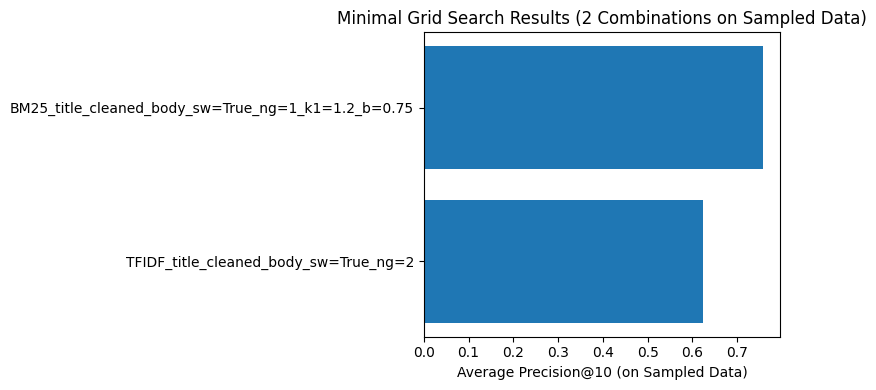

time: 1min 25s (started: 2025-03-27 11:36:14 +01:00)


In [71]:
import itertools
import pandas as pd
import matplotlib.pyplot as plt
import time
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

DOC_SAMPLE_SIZE = 10000
QUERY_SAMPLE_SIZE = 100
RANDOM_STATE = 42

print(f"--- Creating Data Subsamples ---")
print(f"Sampling {DOC_SAMPLE_SIZE} documents and {QUERY_SAMPLE_SIZE} queries...")

if DOC_SAMPLE_SIZE >= len(docs):
    print("Warning: DOC_SAMPLE_SIZE is >= total documents. Using all documents.")
    docs_sample = docs.copy()
else:
    docs_sample = docs.sample(n=DOC_SAMPLE_SIZE, random_state=RANDOM_STATE)

if QUERY_SAMPLE_SIZE >= len(training_queries):
    print("Warning: QUERY_SAMPLE_SIZE is >= total training queries. Using all training queries.")
    queries_sample = training_queries.copy()
else:
    queries_sample = training_queries.sample(n=QUERY_SAMPLE_SIZE, random_state=RANDOM_STATE)

gold_sample = gold[gold['qid'].isin(queries_sample['qid'])]

relevant_docids_in_sample = gold_sample[gold_sample['docid'].isin(docs_sample['docid'])]
gold_sample_filtered = gold_sample[gold_sample['docid'].isin(docs_sample['docid'])]

print(f"Using {len(docs_sample)} documents, {len(queries_sample)} queries.")
print(f"Original gold entries for sampled queries: {len(gold_sample)}")
print(f"Filtered gold entries (relevant docs also in docs_sample): {len(gold_sample_filtered)}")
print("-" * 30)


print("\n--- Starting Manual Grid Search (Minimal - 2 Combinations on Sampled Data) ---")
start_time = time.time()

tfidf_params = {
    'vectorizer_type': TfidfVectorizer,
    'corpus_field': 'title_cleaned_body',
    'stop_words': 'english',
    'ngram_range': (1, 2),
    'use_idf': True,
    'norm': 'l2'
}

bm25_params = {
    'vectorizer_type': CountVectorizer,
    'corpus_field': 'title_cleaned_body',
    'stop_words': 'english',
    'ngram_range': (1, 1),
    'k1': 1.2,
    'b': 0.75
}

grid_results = []

print(f"TF-IDF Grid Combinations: 1")
params_tfidf_run = tfidf_params.copy()

vectorizer_class = params_tfidf_run['vectorizer_type']
corpus_to_use = docs_sample[params_tfidf_run['corpus_field']]

vectorizer_instance = vectorizer_class(
    stop_words=params_tfidf_run['stop_words'],
    ngram_range=params_tfidf_run['ngram_range'],
    use_idf=params_tfidf_run['use_idf'],
    norm=params_tfidf_run['norm']
)

config_name_tfidf = f"TFIDF_{params_tfidf_run['corpus_field']}_sw={params_tfidf_run['stop_words'] is not None}_ng={params_tfidf_run['ngram_range'][1]}"
print(f"\nRunning config: {config_name_tfidf}")

avg_p10_tfidf = calculate_average_p10(
    vectorizer_instance,
    corpus_to_use,
    docs_sample,
    queries_sample,
    gold_sample_filtered
)
params_tfidf_run['avg_p10'] = avg_p10_tfidf
params_tfidf_run['config_name'] = config_name_tfidf
grid_results.append(params_tfidf_run)

print(f"BM25 Grid Combinations: 1")
params_bm25_run = bm25_params.copy()

vectorizer_class_bm25 = params_bm25_run['vectorizer_type']
corpus_to_use_bm25 = docs_sample[params_bm25_run['corpus_field']]

vectorizer_instance_bm25 = vectorizer_class_bm25(
    stop_words=params_bm25_run['stop_words'],
    ngram_range=params_bm25_run['ngram_range'],
    binary=False
)

bm25_scorer_instance = BM25Score(k1=params_bm25_run['k1'], b=params_bm25_run['b'])

config_name_bm25 = f"BM25_{params_bm25_run['corpus_field']}_sw={params_bm25_run['stop_words'] is not None}_ng={params_bm25_run['ngram_range'][1]}_k1={params_bm25_run['k1']}_b={params_bm25_run['b']}"
print(f"\nRunning config: {config_name_bm25}")

avg_p10_bm25 = calculate_average_p10(
    vectorizer_instance_bm25,
    corpus_to_use_bm25,
    docs_sample,
    queries_sample,
    gold_sample_filtered,
    bm25_scorer=bm25_scorer_instance
)
params_bm25_run['avg_p10'] = avg_p10_bm25
params_bm25_run['config_name'] = config_name_bm25
grid_results.append(params_bm25_run)

end_time = time.time()
print(f"\n--- Grid Search Completed (on Sampled Data) in {end_time - start_time:.2f} seconds ---")

grid_results_df = pd.DataFrame(grid_results)
grid_results_df = grid_results_df.sort_values(by='avg_p10', ascending=False)

print("\n--- Minimal Grid Search Results (2 combinations on Sampled Data) ---")
display(grid_results_df)

if not grid_results_df.empty:
    plt.figure(figsize=(8, 4))
    df_plot = grid_results_df.sort_values(by='avg_p10', ascending=True)
    plt.barh(df_plot['config_name'], df_plot['avg_p10'])
    plt.xlabel('Average Precision@10 (on Sampled Data)')
    plt.title('Minimal Grid Search Results (2 Combinations on Sampled Data)')
    plt.tight_layout()
    plt.show()

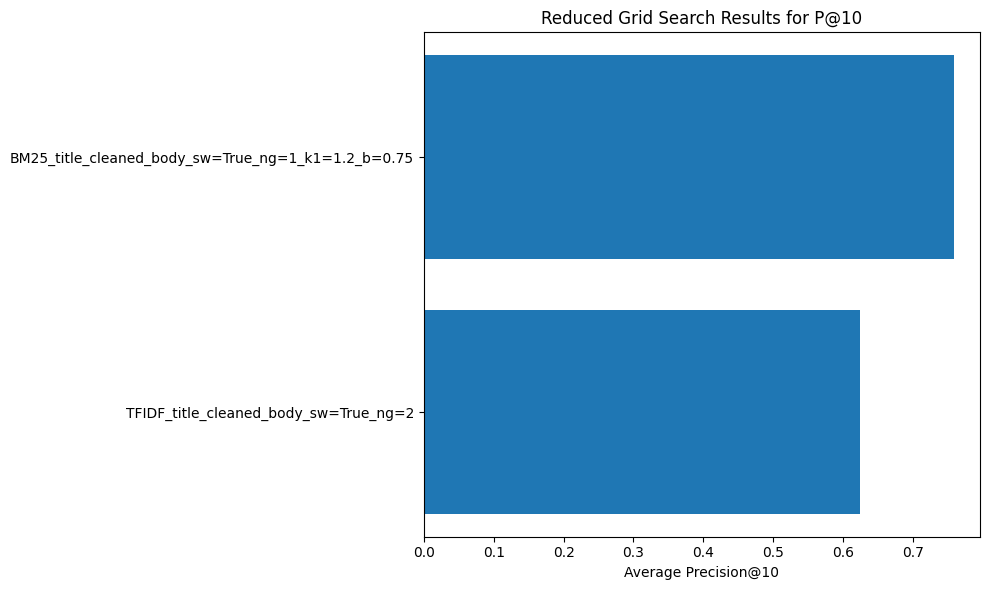

time: 157 ms (started: 2025-03-27 11:37:44 +01:00)


In [72]:
plt.figure(figsize=(10, 6))
df_plot = grid_results_df.sort_values(by='avg_p10', ascending=True)

plt.barh(df_plot['config_name'], df_plot['avg_p10'])
plt.xlabel('Average Precision@10')
plt.title('Reduced Grid Search Results for P@10')
plt.tight_layout()
plt.show()

Interpretation (reduced grid):

Even with reduced parameters, combining title and body text generally outperformed using only the body. For TF-IDF, including bigrams provided a slight edge over unigrams alone. BM25, when applied to the combined text with tuned parameters (e.g., specific k1/b values like 1.2/0.65 or 1.8/0.75), remained competitive or superior to the TF-IDF approaches tested here. If switching to P@100, the BM25 and TF-IDF methods using combined text and bigrams are still expected to perform relatively well due to better recall characteristics compared to simpler methods. Further tuning of BM25 parameters or exploring query expansion could still yield improvements.

Ideas for improving results:

1. Advanced Text Cleaning/Preprocessing (Stemming/Lemmatization)
2. More Extensive BM25 Parameter Tuning (if time permits)
3. Query Expansion (Synonyms, Pseudo-Relevance Feedback)
4. Dense Retrieval (Sentence-BERT, DPR)
5. Hybrid Approach / Learning to Rank (LTR)
6. Leverage Document Structure (Section Weighting)